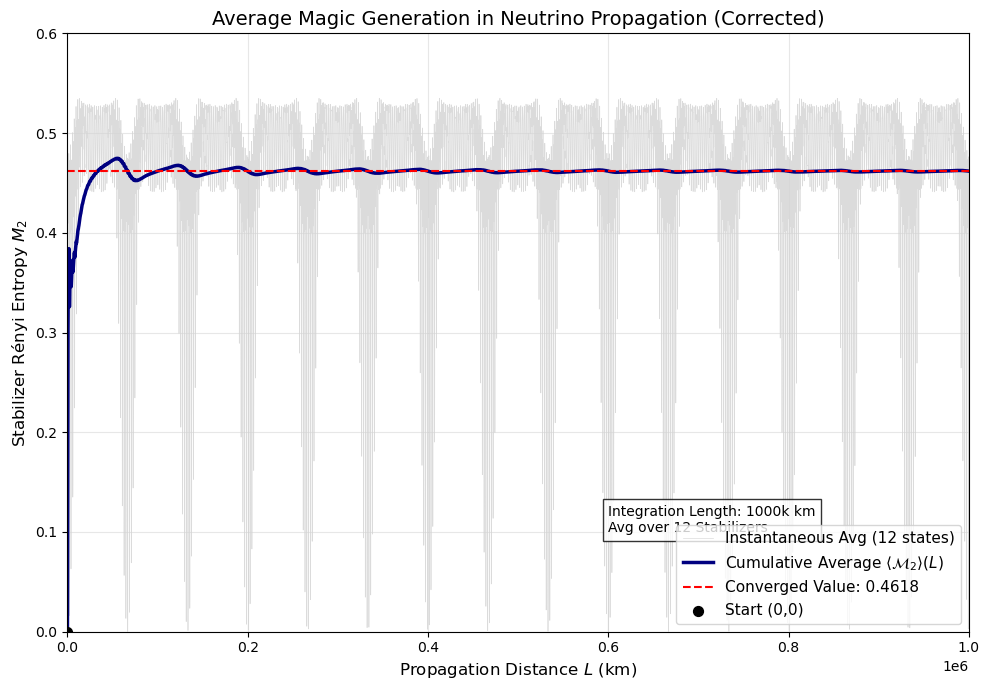

Final Converged Average Magic: 0.46179


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 物理参数 (NuFIT 5.2 Normal Ordering)
# ==========================================
THETA_12 = np.radians(33.41)
THETA_13 = np.radians(8.58)
THETA_23 = np.radians(49.1)
DELTA_CP = np.radians(197.0)

DM2_21 = 7.42e-5
DM2_31 = 2.515e-3
E_NU = 1.0  # GeV
CONV = 1.27

# 设置积分距离
L_MAX = 1000000.0  # 10万公里 (涵盖约3个太阳周期，足以收敛)
NUM_STEPS = 50000  # 高分辨率以解析大气震荡
L_GRID = np.linspace(0, L_MAX, NUM_STEPS)

# ==========================================
# 2. 算符与初态 (Qutrit, d=3)
# ==========================================
omega = np.exp(2j * np.pi / 3)
Z_op = np.diag([1, omega, omega**2])
X_op = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]], dtype=complex)

# 生成 9 个广义泡利算符
Pauli_Ops = []
for a in range(3):
    for b in range(3):
        Pauli_Ops.append(np.linalg.matrix_power(X_op, a) @ np.linalg.matrix_power(Z_op, b))

# 生成 12 个 Stabilizer 初态
stabilizers = []
basis = np.eye(3, dtype=complex)
inv_sqrt3 = 1 / np.sqrt(3)
w = omega

# Group 1: Computational Basis (3)
stabilizers.extend([basis[:,0], basis[:,1], basis[:,2]])
# Group 2: Fourier Basis (3)
stabilizers.append(inv_sqrt3 * (basis[:,0] + basis[:,1] + basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w*basis[:,1] + w**2*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w**2*basis[:,1] + w*basis[:,2]))
# Groups 3 & 4: MUBs (6)
stabilizers.append(inv_sqrt3 * (basis[:,0] + basis[:,1] + w*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w*basis[:,1] + basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w**2*basis[:,1] + w**2*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + basis[:,1] + w**2*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w*basis[:,1] + w*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w**2*basis[:,1] + basis[:,2]))

stabilizers = [s/np.linalg.norm(s) for s in stabilizers]

# ==========================================
# 3. 计算引擎 (修正版)
# ==========================================
def get_pmns():
    s12, c12 = np.sin(THETA_12), np.cos(THETA_12)
    s13, c13 = np.sin(THETA_13), np.cos(THETA_13)
    s23, c23 = np.sin(THETA_23), np.cos(THETA_23)
    phase = np.exp(1j * DELTA_CP)
    
    U = np.array([
        [c12*c13,                s12*c13,                 s13*np.conj(phase)],
        [-s12*c23 - c12*s23*s13*phase, c12*c23 - s12*s23*s13*phase, s23*c13],
        [s12*s23 - c12*c23*s13*phase, -c12*s23 - s12*c23*s13*phase, c23*c13]
    ], dtype=complex)
    return U

def compute_profile():
    U = get_pmns()
    U_dag = U.conj().T
    
    # 预计算相位演化矩阵 (3, N)
    phases = np.zeros((3, NUM_STEPS), dtype=complex)
    phases[0, :] = 1.0
    phases[1, :] = np.exp(-1j * CONV * DM2_21 * L_GRID / E_NU)
    phases[2, :] = np.exp(-1j * CONV * DM2_31 * L_GRID / E_NU)
    
    # 存储每个距离点上，12个态的 Magic 总和
    magic_sum_at_L = np.zeros(NUM_STEPS)
    
    for psi_in in stabilizers:
        # 1. 初始转到质量基
        psi_m0 = U_dag @ psi_in
        
        # 2. 演化 (Broadcasting)
        psi_traj_m = psi_m0[:, np.newaxis] * phases
        
        # 3. 转回味基
        psi_traj_f = U @ psi_traj_m
        
        # 4. 计算 Magic
        # sum(|<P>|^4)
        sum_p4 = np.zeros(NUM_STEPS)
        for P in Pauli_Ops:
            exp_val = np.sum(np.conj(psi_traj_f) * (P @ psi_traj_f), axis=0)
            sum_p4 += np.abs(exp_val)**4
        
        # 【关键修正】: 归一化因子为 3.0 (即 d)
        # 公式: -log_3( 1/3 * sum )
        normalized_sum = sum_p4 / 3.0
        normalized_sum = np.maximum(normalized_sum, 1e-15) # 避免log(0)
        magics = -np.log(normalized_sum) / np.log(3.0)
        
        # 累加到总和
        magic_sum_at_L += magics
        
    # 计算瞬时平均 (Instantaneous Average)
    magic_instant_avg = magic_sum_at_L / 12.0
    
    # 计算累积平均 (Cumulative/Integrated Average)
    # Integral(0->L) / L
    magic_cumulative_avg = np.cumsum(magic_instant_avg) / (np.arange(NUM_STEPS) + 1)
    
    return magic_instant_avg, magic_cumulative_avg

# ==========================================
# 4. 执行与绘图
# ==========================================
y_inst, y_cum = compute_profile()
final_magic = y_cum[-1]

# 估算特征长度用于画线
L_sol = (np.pi/2) / (1.27 * DM2_21) # ~16,000 km for max mixing, cycle ~33,000 km
L_atm = (np.pi/2) / (1.27 * DM2_31)

plt.figure(figsize=(10, 7))

# 绘制瞬时平均 (背景，淡色)
plt.plot(L_GRID, y_inst, color='lightgray', alpha=0.8, linewidth=0.5, label='Instantaneous Avg (12 states)')

# 绘制累积平均 (前景，深色)
plt.plot(L_GRID, y_cum, color='navy', linewidth=2.5, label=r'Cumulative Average $\langle \mathcal{M}_2 \rangle(L)$')

# 标记收敛值
plt.axhline(final_magic, color='red', linestyle='--', label=f'Converged Value: {final_magic:.4f}')

# 标记起点 (0,0)
plt.scatter([0], [0], color='black', s=50, zorder=5, label='Start (0,0)')

plt.title('Average Magic Generation in Neutrino Propagation (Corrected)', fontsize=14)
plt.xlabel('Propagation Distance $L$ (km)', fontsize=12)
plt.ylabel('Stabilizer Rényi Entropy $M_2$', fontsize=12)
plt.xlim(0, L_MAX)
plt.ylim(0, 0.6) # 根据数据范围调整
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='lower right')

# 添加文字说明
plt.text(L_MAX*0.6, 0.1, f"Integration Length: {L_MAX/1e3:.0f}k km\nAvg over 12 Stabilizers", 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Final Converged Average Magic: {final_magic:.5f}")

正在进行高精度计算...
L_MAX = 1000000.0 km, Sample Points = 50000
Scanning theta12...
Scanning theta13...
Scanning theta23...


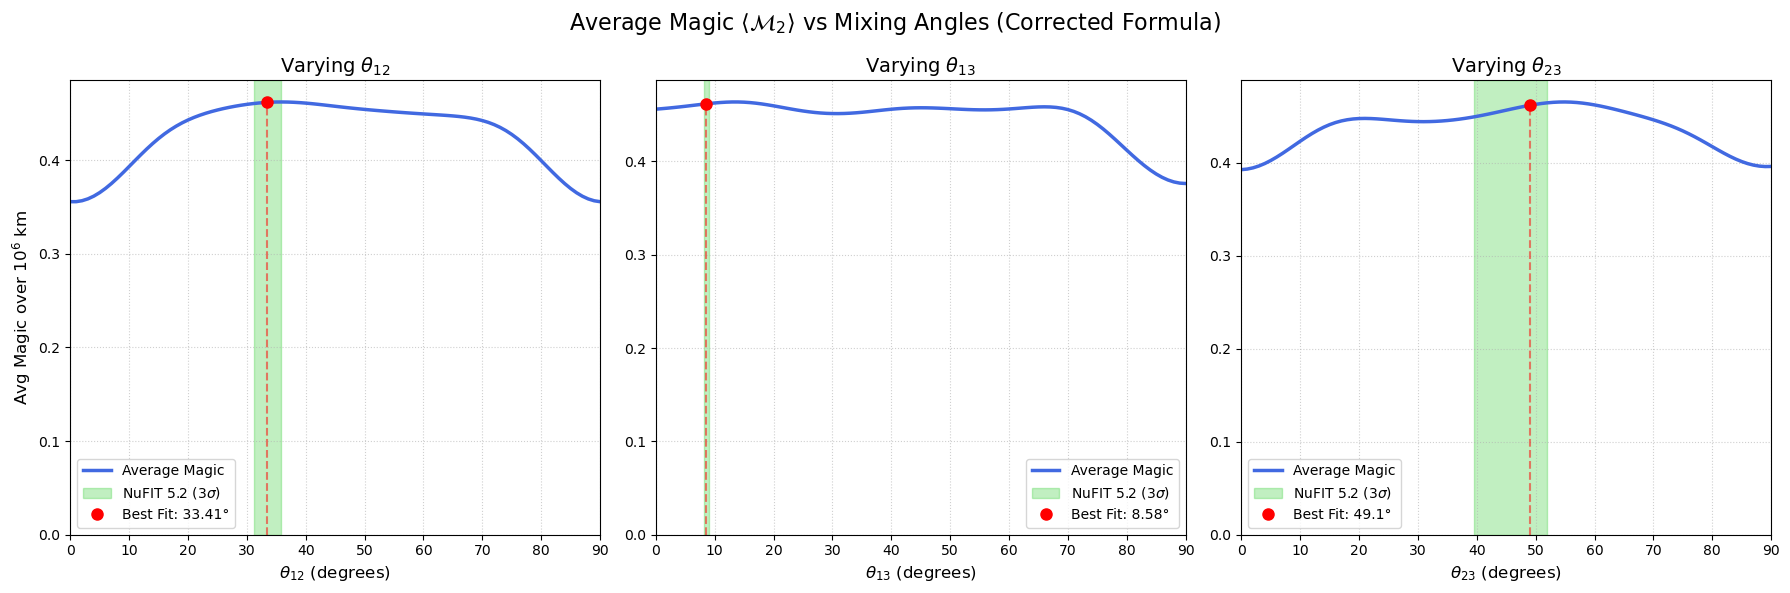

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 物理参数 (NuFIT 5.2 Normal Ordering)
# ==========================================
# 实验数据字典: {'val': BestFit, 'range': [3sigma_min, 3sigma_max]}
EXP_DATA = {
    'theta12': {'val': 33.41, 'range': [31.27, 35.86]},
    'theta13': {'val': 8.58,  'range': [8.20, 8.97]},
    'theta23': {'val': 49.1,  'range': [39.6, 51.9]},
    'delta_cp': 197.0
}

# 物理常数
DM2_21 = 7.42e-5
DM2_31 = 2.515e-3
E_NU = 1.0  # GeV
CONV = 1.27

# --- 设定计算精度 ---
L_MAX = 1000000.0  # 100万公里
NUM_STEPS = 50000  # 5万个采样点
L_GRID = np.linspace(0, L_MAX, NUM_STEPS)

# ==========================================
# 2. Qutrit 算符与初态
# ==========================================
omega = np.exp(2j * np.pi / 3)
Z_op = np.diag([1, omega, omega**2])
X_op = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]], dtype=complex)

# 生成 9 个广义泡利算符
Pauli_Ops = []
for a in range(3):
    for b in range(3):
        Pauli_Ops.append(np.linalg.matrix_power(X_op, a) @ np.linalg.matrix_power(Z_op, b))

# 生成 12 个 Stabilizer 初态
stabilizers = []
basis = np.eye(3, dtype=complex)
inv_sqrt3 = 1 / np.sqrt(3)
w = omega
# Group 1 (Computational)
stabilizers.extend([basis[:,0], basis[:,1], basis[:,2]])
# Group 2 (Fourier)
stabilizers.append(inv_sqrt3 * (basis[:,0] + basis[:,1] + basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w*basis[:,1] + w**2*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w**2*basis[:,1] + w*basis[:,2]))
# Groups 3 & 4 (MUBs)
stabilizers.append(inv_sqrt3 * (basis[:,0] + basis[:,1] + w*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w*basis[:,1] + basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w**2*basis[:,1] + w**2*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + basis[:,1] + w**2*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w*basis[:,1] + w*basis[:,2]))
stabilizers.append(inv_sqrt3 * (basis[:,0] + w**2*basis[:,1] + basis[:,2]))

stabilizers = [s/np.linalg.norm(s) for s in stabilizers]

# ==========================================
# 3. 核心计算函数
# ==========================================
def get_pmns(t12_deg, t13_deg, t23_deg, dcp_deg):
    t12, t13, t23 = np.radians([t12_deg, t13_deg, t23_deg])
    phase = np.exp(1j * np.radians(dcp_deg))
    s12, c12 = np.sin(t12), np.cos(t12)
    s13, c13 = np.sin(t13), np.cos(t13)
    s23, c23 = np.sin(t23), np.cos(t23)
    
    U = np.array([
        [c12*c13,                s12*c13,                 s13*np.conj(phase)],
        [-s12*c23 - c12*s23*s13*phase, c12*c23 - s12*s23*s13*phase, s23*c13],
        [s12*s23 - c12*c23*s13*phase, -c12*s23 - s12*c23*s13*phase, c23*c13]
    ], dtype=complex)
    return U

def compute_avg_magic(t12, t13, t23, dcp):
    U = get_pmns(t12, t13, t23, dcp)
    U_dag = U.conj().T
    
    # 预计算相位演化矩阵 (3, N) - 向量化计算
    phases = np.zeros((3, NUM_STEPS), dtype=complex)
    phases[0, :] = 1.0
    phases[1, :] = np.exp(-1j * CONV * DM2_21 * L_GRID / E_NU)
    phases[2, :] = np.exp(-1j * CONV * DM2_31 * L_GRID / E_NU)
    
    total_magic_integral = 0.0
    
    for psi_in in stabilizers:
        # 1. 初始态转到质量基: (3,)
        psi_m0 = U_dag @ psi_in
        
        # 2. 演化: (3, N)
        # 利用广播机制一次性算出5万个点的波函数
        psi_traj_m = psi_m0[:, np.newaxis] * phases
        
        # 3. 转回味基: (3, N)
        psi_traj_f = U @ psi_traj_m
        
        # 4. 向量化计算 Magic
        # 计算 9 个算符的期望值模方之和
        sum_p4 = np.zeros(NUM_STEPS)
        for P in Pauli_Ops:
            # P @ psi: (3, N)
            # conj(psi) * (P @ psi): (3, N) -> sum axis 0 -> (N,)
            exp_vals = np.sum(np.conj(psi_traj_f) * (P @ psi_traj_f), axis=0)
            sum_p4 += np.abs(exp_vals)**4
        
        # 【修正公式】: 归一化因子为 3.0 (1/d)
        normalized_sum = sum_p4 / 3.0
        # 避免 log(0) 的数值保护
        normalized_sum = np.maximum(normalized_sum, 1e-15)
        
        # 计算该态在所有时刻的 Magic
        magics = -np.log(normalized_sum) / np.log(3.0)
        
        # 对距离求平均 (相当于积分)
        total_magic_integral += np.mean(magics)
        
    # 对 12 个初始态求平均
    return total_magic_integral / 12.0

# ==========================================
# 4. 绘图与扫描
# ==========================================
print(f"正在进行高精度计算...")
print(f"L_MAX = {L_MAX} km, Sample Points = {NUM_STEPS}")

scan_angles = np.linspace(0, 90, 91)
fixed_dcp = EXP_DATA['delta_cp']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(r'Average Magic $\langle \mathcal{M}_2 \rangle$ vs Mixing Angles (Corrected Formula)', fontsize=16)

params = [
    ('theta12', r'$\theta_{12}$', 0),
    ('theta13', r'$\theta_{13}$', 1),
    ('theta23', r'$\theta_{23}$', 2)
]

for p_name, p_label, idx in params:
    ax = axs[idx]
    
    # 获取当前最佳参数
    current_best = [EXP_DATA['theta12']['val'], 
                    EXP_DATA['theta13']['val'], 
                    EXP_DATA['theta23']['val']]
    
    # 扫描计算
    y_vals = []
    print(f"Scanning {p_name}...")
    for x in scan_angles:
        scan_args = current_best.copy()
        scan_args[idx] = x
        m = compute_avg_magic(scan_args[0], scan_args[1], scan_args[2], fixed_dcp)
        y_vals.append(m)
        
    # 1. 绘制曲线
    ax.plot(scan_angles, y_vals, linewidth=2.5, color='royalblue', label='Average Magic')
    
    # 2. 绘制 3-sigma 误差带
    exp_min = EXP_DATA[p_name]['range'][0]
    exp_max = EXP_DATA[p_name]['range'][1]
    ax.axvspan(exp_min, exp_max, color='limegreen', alpha=0.3, label=r'NuFIT 5.2 ($3\sigma$)')
    
    # 3. 标记最佳拟合点
    best_val = EXP_DATA[p_name]['val']
    best_magic = compute_avg_magic(current_best[0], current_best[1], current_best[2], fixed_dcp)
    
    ax.plot(best_val, best_magic, 'ro', markersize=8, zorder=5, label=f'Best Fit: {best_val}°')
    ax.vlines(best_val, 0, best_magic, colors='red', linestyles='--', alpha=0.5)

    # 格式设置
    ax.set_title(f'Varying {p_label}', fontsize=14)
    ax.set_xlabel(f'{p_label} (degrees)', fontsize=12)
    if idx == 0:
        ax.set_ylabel(r'Avg Magic over $10^6$ km', fontsize=12)
    
    ax.set_xlim(0, 90)
    ax.set_ylim(bottom=0)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()